<a href="https://colab.research.google.com/github/Ranjithkrishnasamy/Urban-electric-gyrocopter-ML-optimization/blob/main/Body_gc_Neural%20network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [100/100], Loss: 0.0214
Maximum Front Convergence: 70.0
Maximum Back Convergence: 43.0
Maximum Top Convergence: 24.0
Predicted Minimum Drag Magnitude: 2063.5244140625


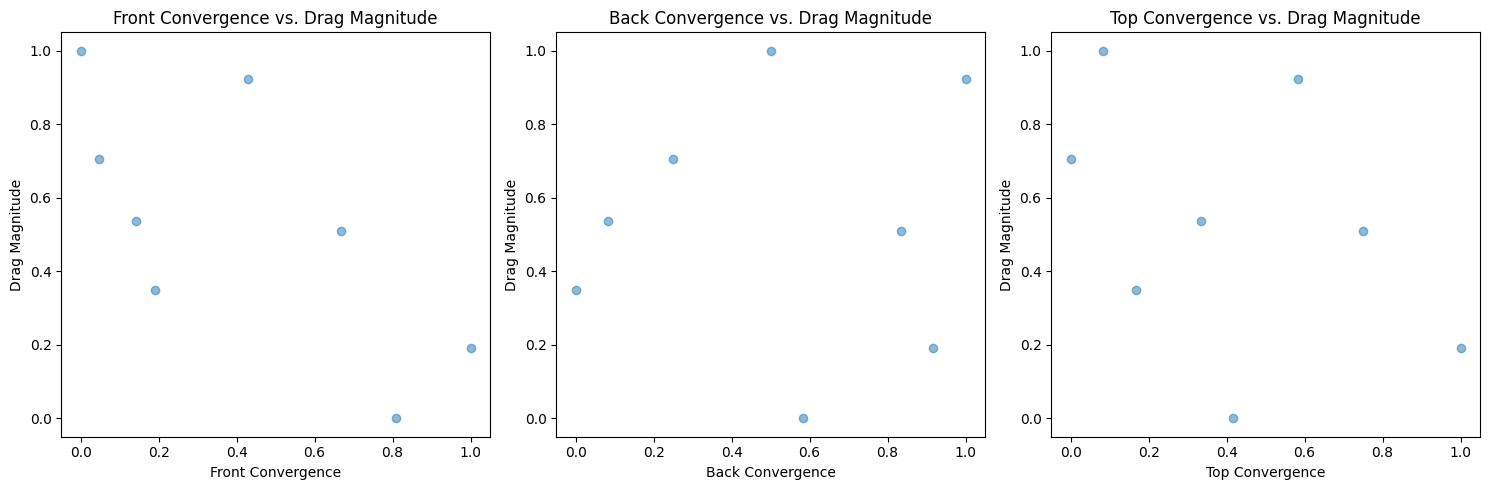

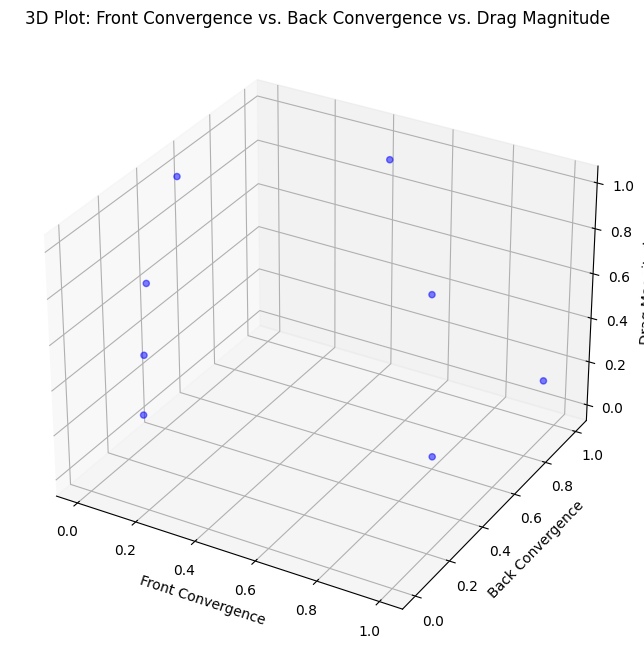

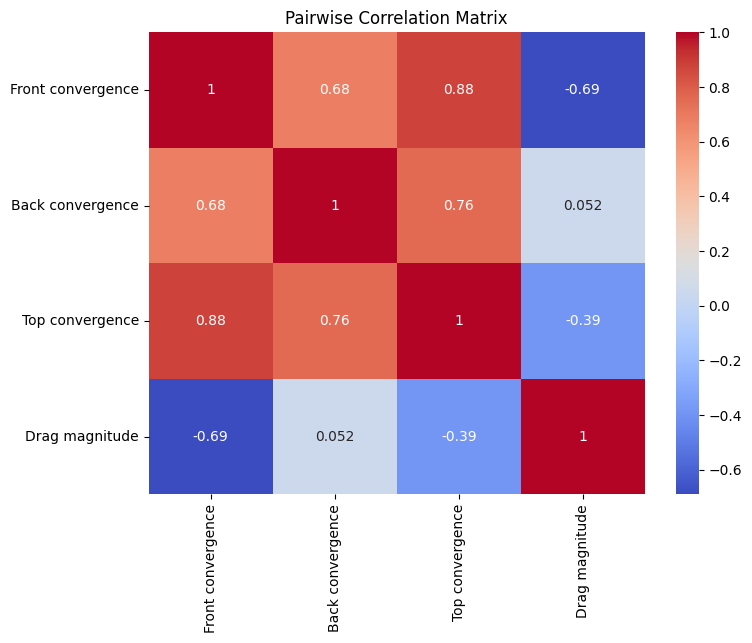

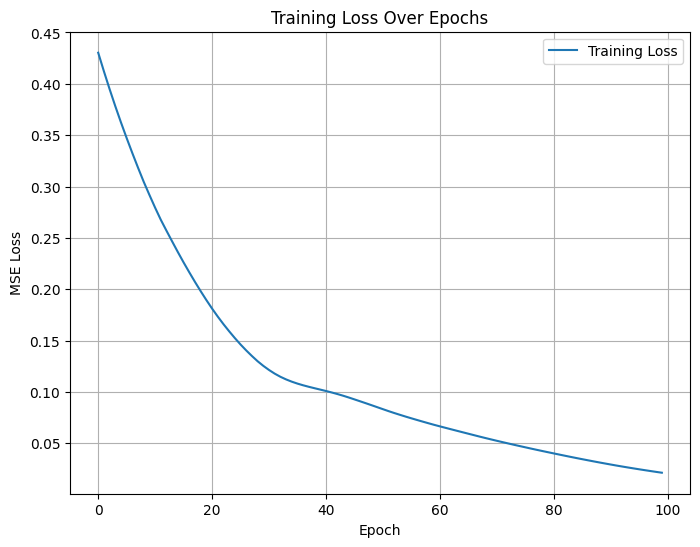

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns  # Import Seaborn for the correlation matrix
from sklearn.metrics import mean_squared_error, r2_score

# Load your dataset
filepath = r'/content/Body set 2 - Copy.xlsx'
data = pd.read_excel(filepath)  # Replace 'your_dataset.csv' with your dataset file

# Define the input and target variables
X = data[['Front convergence', 'Back convergence', 'Top convergence']].values
y = data['Drag magnitude'].values

# Scale the data to ensure values stay within a range (e.g., [0, 1])
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1))

# Find the index corresponding to maximum Front convergence, maximum Back convergence, and maximum Top convergence
max_front_convergence_idx = np.argmax(X[:, 0])
max_back_convergence_idx = np.argmax(X[:, 1])
max_top_convergence_idx = np.argmax(X[:, 2])

# Define a custom neural network
class DragMagnitudeOptimizer(nn.Module):
    def __init__(self, input_dim):
        super(DragMagnitudeOptimizer, self).__init__()  # Corrected 'super' statement
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_dim = X.shape[1]
model = DragMagnitudeOptimizer(input_dim)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists for storing training and validation loss
train_loss_history = []

# Training loop
num_epochs = 100  # You can change this number if needed
for epoch in range(num_epochs):
    inputs = torch.FloatTensor(X)
    targets = torch.FloatTensor(y)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss_history.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Find the input values corresponding to the specified conditions
best_inputs_front_convergence = scaler_x.inverse_transform(X[max_front_convergence_idx].reshape(1, -1))
best_inputs_back_convergence = scaler_x.inverse_transform(X[max_back_convergence_idx].reshape(1, -1))
best_inputs_top_convergence = scaler_x.inverse_transform(X[max_top_convergence_idx].reshape(1, -1))

# Evaluation: Predict the minimum Drag Magnitude
model.eval()
with torch.no_grad():
    min_drag_magnitude_input = torch.FloatTensor(X[max_front_convergence_idx].reshape(1, -1))
    min_drag_magnitude = model(min_drag_magnitude_input)

# Inverse scaling to obtain real values
min_drag_magnitude = scaler_y.inverse_transform(min_drag_magnitude.numpy())

# Visualization: Scatter plots and 3D plot
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(X[:, 0], y, alpha=0.5)
plt.xlabel('Front Convergence')
plt.ylabel('Drag Magnitude')
plt.title('Front Convergence vs. Drag Magnitude')

plt.subplot(132)
plt.scatter(X[:, 1], y, alpha=0.5)
plt.xlabel('Back Convergence')
plt.ylabel('Drag Magnitude')
plt.title('Back Convergence vs. Drag Magnitude')

plt.subplot(133)
plt.scatter(X[:, 2], y, alpha=0.5)
plt.xlabel('Top Convergence')
plt.ylabel('Drag Magnitude')
plt.title('Top Convergence vs. Drag Magnitude')

plt.tight_layout()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], y, c='b', marker='o', alpha=0.5)
ax.set_xlabel('Front Convergence')
ax.set_ylabel('Back Convergence')
ax.set_zlabel('Drag Magnitude')
ax.set_title('3D Plot: Front Convergence vs. Back Convergence vs. Drag Magnitude')

# Pairwise correlation matrix
corr_matrix = data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Pairwise Correlation Matrix')

# Loss visualization
plt.figure(figsize=(8, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)

# Print the results
print(f"Maximum Front Convergence: {best_inputs_front_convergence[0][0]}")
print(f"Maximum Back Convergence: {best_inputs_back_convergence[0][1]}")
print(f"Maximum Top Convergence: {best_inputs_top_convergence[0][2]}")
print(f"Predicted Minimum Drag Magnitude: {min_drag_magnitude[0][0]}")

plt.show()
